<a href="https://colab.research.google.com/github/javierFerreroM/NLP_Project/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto de tweets de acuerdo a 11 sentimientos ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust').
Disponéis de un conjunto de 3561 tweets etiquetas para entrenar y validar el modelo o modelos necesarios, en el archivo 'sem_eval_train_es.csv'.

Cada alumno tiene que validar sus modelos sobre el conjunto ciego de test con el nombre 'sem_eval_test_blank_es.csv'. Cada Tweet tiene un ID (primera columna) que tenéis que mantener en vuestra solución. Debéis aplicar vuestro modelo entrenado a este conjunto y guardarlo en un archivo CSV de nombre 'soluciones_nombre_apellido1_apellido2.csv'. El archivo CSV a entregar debe tener esta estructura de Pandas:

<class 'pandas.core.frame.DataFrame'>  
RangeIndex: 679 entries, 0 to 678  
Data columns (total 12 columns):  

| #  | Column       |  Non-Null Count  | Dtype |  
|--- | ------       |  --------------  | ----- |  
 0   | ID            | 679 non-null    | object|
 1   | anger         | 679 non-null    | bool  |
 2   | anticipation  | 679 non-null    | bool  |
 3   | disgust       | 679 non-null    | bool  |
 4   | fear          | 679 non-null    | bool  |
 5   | joy           | 679 non-null    | bool  |
 6   | love          | 679 non-null    | bool  |
 7   | optimism      | 679 non-null    | bool  |
 8   | pessimism     | 679 non-null    | bool  |
 9   | sadness       | 679 non-null    | bool  |
 10  | surprise      | 679 non-null    | bool  |
 11  | trust         | 679 non-null    | bool  |
dtypes: bool(11), object(1)
Si el archivo no tiene exactamente esa estructura no se podrá evaluar.

Entrega:

Cada alumno deberá entregar a través de esta tarea habilitada en AV el archivo CSV de las predicciones en el conjunto ciego de test y todo el código en Python utilizado tanto para el entrenamiento de los modelos como la inferencia en el conjunto ciego de test. El código Python se entregará como Notebook de Jupyter.

In [150]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [151]:
import pandas as pd
train = pd.read_csv('/content/sem_eval_train_es.csv')
print("Training Set:"% train.columns, train.shape, len(train))
test = pd.read_csv('/content/sem_eval_test_blank_es.csv')
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (3561, 13) 3561
Test Set: (679, 2) 679


Es siempre una buena idea limpiar los datos obtenidos. Debemos eliminar signos de puntuación para evitar introducir ruido en el entrenamiento, dado que símbolos de puntuación tales como @, #, !, etc.

Para ello, la biblioteca de python re nos va a permitir buscar expresiones regulares, para eliminar mayúsculas, etc

In [152]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [153]:
import re
from unidecode import unidecode
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower() # pasar todo a minúsculas
    df[text_field] = df[text_field].apply(unidecode) # Eliminar los acentos y símbolos sobre las letras
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  # Eliminar caracteres extraños
    return df
test_clean = clean_text(test, "Tweet")
train_clean = clean_text(train, "Tweet")

In [154]:
train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa ...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,la mala suerte del gato fichame la cara de he...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,a mi tampoco me agrado mucho eso especialment...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,me encanta la terrible hipocresia y doble mor...,True,False,True,False,False,False,False,False,False,False,False


In [155]:
len(train_clean[train_clean['anger']==True])

1155

{'anger': 1155, 'anticipation': 415, 'disgust': 521, 'fear': 373, 'joy': 1087, 'love': 261, 'optimism': 378, 'pessimism': 578, 'sadness': 845, 'surprise': 169, 'trust': 175}


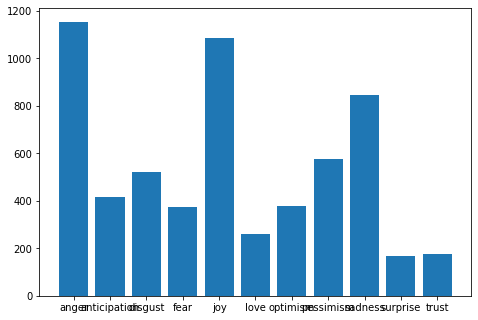

In [156]:
import matplotlib.pyplot as plt
#Check if the classes are imbalanced
count = {}
for i in train_clean.columns:
  if i not in ['ID', 'Tweet']:
    count[i] = len(train_clean[train_clean[i]==True])
print(count)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(count.keys(),count.values())
plt.show()

In [157]:
# La clase con el menor número de repeticiones es 'surprise'  = 169
thresholdVal = min(count.values())
print(thresholdVal)

169


In [158]:
train_data_balanced = pd.DataFrame(columns = train_clean.columns)
for i in train_clean.columns:
  if i not in ['ID', 'Tweet']:
    train_data_balanced = pd.concat([train_data_balanced,train_clean[train_clean[i]==True].sample(thresholdVal)], axis=0).drop_duplicates().reset_index(drop=True)
    #train_clean = train_clean.drop(train_clean[train_clean[i]==True].sample(thresholdVal).index, axis = 0)
    
train_data_balanced

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01493,terrible velero estan haciend,True,False,True,False,False,False,False,False,True,False,False
1,2018-Es-00368,fijate que son 5 por todos es lamentable cas...,True,False,True,False,False,False,False,False,True,False,False
2,2018-Es-00125,encima que le escribi 84 cosas me contesta 3 p...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-03924,por tragica noticia puse a profundizar un cach...,True,False,False,False,False,False,False,False,True,False,False
4,2018-Es-05737,es la peor se tiro al sofa a ver master chef ...,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,2018-Es-06297,lombardo valio la pena,False,False,False,False,True,False,True,False,False,False,True
1558,2018-Es-05929,hoy me senti como mi idolo si como julio cesar...,False,False,False,False,True,False,False,False,False,False,True
1559,2018-Es-02043,dejame sobrepasar tus zonas de peligro hasta p...,False,True,False,False,False,False,False,False,False,False,True
1560,2018-Es-01881,ir a su casa y ponerle una goliza en el fifa m...,False,False,False,False,True,False,False,False,False,False,True


Las columnas no son excluyentes. Cada tweet puede ser de más de un tipo de sentimiento

In [159]:
len(train_data_balanced) == len(train_data_balanced['ID'].unique())

True

Con los datos ya tratados y listos, podemos empezar el entrenamiento

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_data_balanced, test_size = 0.2, random_state = 1)

ValueError: ignored

In [ ]:
# Training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', SGDClassifier()),
])